# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель исследования** - выполнить следующие задачи:

1. Загрузить и подготовить данные.
2. Подготовить выборки для обучения.
3. Обучить разные модели.
4. Проанализировать время обучения, время предсказания и качество моделей.
5. Выбрать лучшую модель.

**Ход исследования**

Данные находятся в файле `/datasets/autos.csv`. О качестве данных нам ничего не известно. Значит перед исследовательской работой понадбится просмотреть данные. Проверим общую информацию и проведём предобработку данных, чтобы исправить ошибки.

После подготовки данных займёмся обучением моделей. Опираясь на критерии заказчика, выберем лучшую модель и проверим её качество на тестовой выборке.

## Подготовка данных

### Обзор данных

In [1]:
#подключим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import GridSearchCV
#from sklearn.pipeline import make_pipeline

In [2]:
#прочитаем файл
data = pd.read_csv('/datasets/autos.csv')

In [3]:
#выведем первые 5 строк таблицы
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
#выведем общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
#оценим данные в таблице методом describe
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
#проверим колличество пропусков в %
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000


**Вывод**

В каждой строке таблицы - данные о технических характеристиках, комплектации и ценах автомобилей. Поскольку наши модели должны определять рыночную стоимость автомобиля, то признаки, которые никак не связаны с состоянием автомобиля, можно будет удалить на этапе предобработки. 

Мы видим, что в 5 столбцах присутствуют пропуски. В некоторых столбцах есть аномальные значения. Этого уже достаточно, чтобы приступить к предобработке данных.

### Предобработка данных

In [7]:
#удалим столбцы, которые не понадобятся для обучения моделей
data = data.drop(['DateCrawled','DateCreated','NumberOfPictures','PostalCode','LastSeen'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [8]:
#посмотрим на количество дубликатов
data.duplicated().sum()

27543

Пока не будем убирать дубликаты, ибо есть возможность, что в ходе предобработки большая часть и так исчезнет. 

In [9]:
#посмотрим на уникальные наименования и их количество в категорильных признаках, количество и % пустых строк
temp = data.copy() 
list_c = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
for col_l in list_c:
    print('-'* 25)
    print(col_l, temp[col_l].sort_values().nunique())
    print(col_l, temp[col_l].sort_values().unique())
    print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
          ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

-------------------------
VehicleType 8
VehicleType ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
VehicleType : кол-во NaN 37490 , процент NaN 10.58 %
-------------------------
Gearbox 2
Gearbox ['auto' 'manual' nan]
Gearbox : кол-во NaN 19833 , процент NaN 5.6 %
-------------------------
Model 250
Model ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'cr

In [10]:
#посмотрим на значения целевого признака
data['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

Удалим строки, где отсутствует цена, ибо заполнить мы их никак не можем.

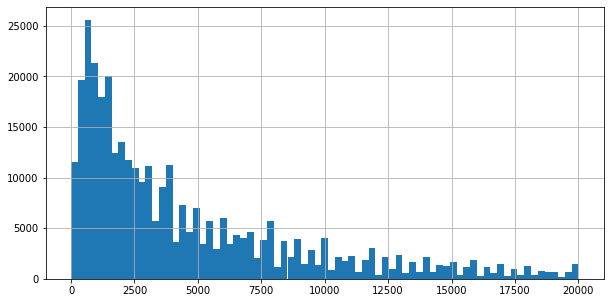

In [11]:
#удалим 0 цену и построим распределение
data = data.query('Price > 0')
data['Price'].hist(bins=75, figsize=(10, 5))
plt.show()

Избавимся от аномальных значений в следующих столбцах:

* RegistrationYear - поставим ограничение от 1900 до 2022 года, ибо значения меньше 1900 и больше 2022 невозможны.
* Power - ограничим значение лошадиных сил от 10 до 1200. Значения после 1200 возможны, но слишком редки.

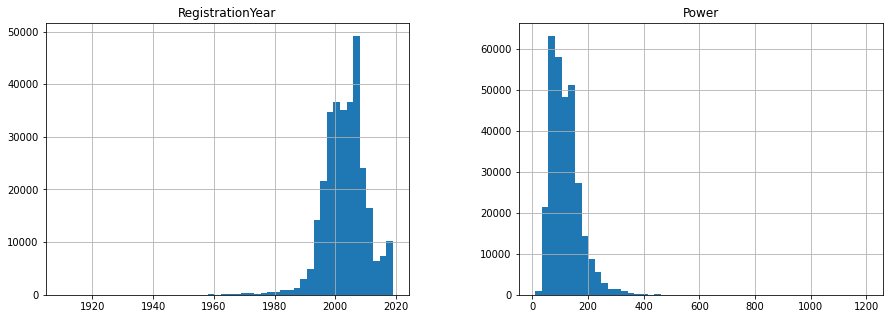

In [12]:
#ограничим год и л.с., и построим графики
data = data.query('1900 < RegistrationYear < 2022 and 10 < Power < 1200')
data[['RegistrationYear', 'Power']].hist(bins=50, figsize=(15, 5))
plt.show()

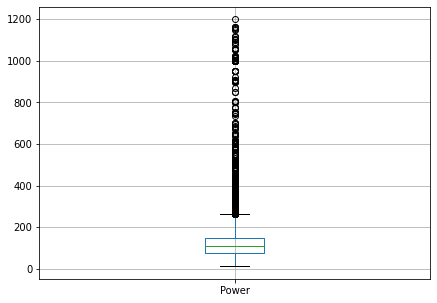

In [13]:
#чуть подробнее глянем на распределение мощности
data.boxplot(column='Power', figsize=(7, 5))
plt.show()

Поясним, какие значения пропущены и как их можно обработать:

* VehicleType - заполним пропуски наиболее частой категорией из столбца Brand и Model
* Gearbox - пустые значения заменим на manual
* Model - заполним пропуски наиболее частой категорией из столбца Brand и RegistrationYear
* FuelType - заполним пропуски наиболее частой категорией из столбца Brand и Model
* Repaired - заменим на no, так как люди могли просто не заполнять это поле, если машина не чинилась 

In [14]:
#заменим значения в Repaired и Gearbox
data['Repaired'].fillna('no', inplace=True)
data['Gearbox'].fillna('manual', inplace=True)

In [15]:
#посмотрим на самые часто встречающиеся категории
data[['Brand', 'Model', 'RegistrationYear']].mode()

,Brand,Model,RegistrationYear
0,volkswagen,golf,1999


In [16]:
#создадим функцию для замены пропущенных значений
def fill_mode(col, col1, col2):
        data[col] = data.groupby([col1, col2])[col].transform(
            lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "unknown")))

In [17]:
#заполним пропуски самыми частыми категориями
fill_mode('Model', 'Brand', 'RegistrationYear')
fill_mode('VehicleType','Brand','Model')
fill_mode('FuelType','Brand','Model')

#заменим unknown на nan
data = data.replace('unknown',np.nan)

In [18]:
#снова посмотрим на количество пропусков и дубликатов
display(pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm'))
print('Сумма дубликатов:', data.duplicated().sum())

,0
Price,0.000000
VehicleType,0.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,1.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,0.000000
Brand,0.000000


Сумма дубликатов: 28604


Видим, что пропусков почти не осталось, а вот дубликаты всё ещё присутствуют, но мы с ними ничего особо не сделаем. Удалим пропуски и дубликаты

In [19]:
#удалим пропуски и дубликаты
data = data.dropna()
data = data.drop_duplicates(ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276437 entries, 0 to 276436
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              276437 non-null  int64 
 1   VehicleType        276437 non-null  object
 2   RegistrationYear   276437 non-null  int64 
 3   Gearbox            276437 non-null  object
 4   Power              276437 non-null  int64 
 5   Model              276437 non-null  object
 6   Kilometer          276437 non-null  int64 
 7   RegistrationMonth  276437 non-null  int64 
 8   FuelType           276437 non-null  object
 9   Brand              276437 non-null  object
 10  Repaired           276437 non-null  object
dtypes: int64(5), object(6)
memory usage: 23.2+ MB


**Выводы**

При подготовке данных мы выполнили следующее:

* удалили признаки, которые никак не повлияют на обучение моделей
* у целевого признака удалили объекты с нулевой ценой
* избавились от аномальных значений 
* заменили значения в двух столбцах
* заполнили пропуски наиболее частой категорией в трёх столбцах
* удалили оставшиеся пропуски и дубликаты

Можно приступать к обучению моделей

## Обучение моделей

Выберем следующие модели для обучения:
* Light GBM
* Линейная регрессия
* Дерево решений

Поскольку Light GBM может нормально работать с категориальными переменными, то скопируем наши данные и не будем их кодировать. Приведём категориальные признаки к формату category и разобьём данные на выборки

In [20]:
data_gbm = data.copy()

In [21]:
data_gbm[list_c] = data_gbm[list_c].astype('category')

In [22]:
#подготовим выборки для Light GMB
features_gbm = data_gbm.drop(['Price'], axis=1)
target_gbm = data_gbm['Price']

features_gbm_train, features_gbm_valid, target_gbm_train, target_gbm_valid = train_test_split(
    features_gbm, target_gbm, train_size=0.6, random_state=42)

features_gbm_valid, features_gbm_test, target_gbm_valid, target_gbm_test = train_test_split(
    features_gbm_valid, target_gbm_valid, test_size=0.5, random_state=42)

print('Размер обучающей выборки:', features_gbm_train.shape[0],'\n'
      'Размер валидационной выборки:', features_gbm_valid.shape[0],'\n'
      'Размер тестовой выборки:', features_gbm_test.shape[0])

Размер обучающей выборки: 165862 
Размер валидационной выборки: 55287 
Размер тестовой выборки: 55288


Для данных к остальным моделям применим кодирование и подготовим выборки, а после проведём  масштабирование

In [23]:
#проведём кодирование через get_dummies
data_dumm = pd.get_dummies(data, drop_first=True)
data_dumm.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
0,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,3600,2008,69,90000,7,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,650,1995,102,150000,10,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
#подготовим выборки
features = data_dumm.drop(['Price'], axis=1)
target = data_dumm['Price']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, train_size=0.6, random_state=42)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=42)

print('Размер обучающей выборки:', features_train.shape[0],'\n'
      'Размер валидационной выборки:', features_valid.shape[0],'\n'
      'Размер тестовой выборки:', features_test.shape[0])

Размер обучающей выборки: 165862 
Размер валидационной выборки: 55287 
Размер тестовой выборки: 55288


In [26]:
#выполним масштабирование
#убираем предупреждение SettingWithCopy
pd.options.mode.chained_assignment = None

#в переменную передаём все численные признаки
numeric = ['RegistrationYear','Power','Kilometer', 'RegistrationMonth']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Приступим к обучению моделей. Сначала проверим модели без подбора гиперпараметров

### Light GBM без подбора гиперпараметров

In [27]:
%%time
gbm = LGBMRegressor()
gbm.fit(features_gbm_train, target_gbm_train, 
        eval_set=[(features_gbm_valid, target_gbm_valid)], eval_metric='rmse',
        categorical_feature=list_c)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'Repaired', 'VehicleType']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 4283.99	valid_0's l2: 1.83525e+07
[2]	valid_0's rmse: 3988.72	valid_0's l2: 1.59099e+07
[3]	valid_0's rmse: 3729.07	valid_0's l2: 1.39059e+07
[4]	valid_0's rmse: 3503.66	valid_0's l2: 1.22756e+07
[5]	valid_0's rmse: 3301.2	valid_0's l2: 1.08979e+07
[6]	valid_0's rmse: 3117.2	valid_0's l2: 9.71691e+06
[7]	valid_0's rmse: 2949.04	valid_0's l2: 8.69681e+06
[8]	valid_0's rmse: 2808.7	valid_0's l2: 7.88878e+06
[9]	valid_0's rmse: 2678.37	valid_0's l2: 7.17369e+06
[10]	valid_0's rmse: 2564.7	valid_0's l2: 6.57769e+06
[11]	valid_0's rmse: 2467.95	valid_0's l2: 6.0908e+06
[12]	valid_0's rmse: 2379.53	valid_0's l2: 5.66218e+06
[13]	valid_0's rmse: 2304.48	valid_0's l2: 5.31062e+06
[14]	valid_0's rmse: 2236	valid_0's l2: 4.9997e+06
[15]	valid_0's rmse: 2177.59	valid_0's l2: 4.74188e+06
[16]	valid_0's rmse: 2123.95	valid_0's l2: 4.51117e+06
[17]	valid_0's rmse: 2078.91	valid_0's l2: 4.32187e+06
[18]	valid_0's rmse: 2036.18	valid_0's l2: 4.14602e+06
[19]	valid_0's rmse: 2001.34

LGBMRegressor()

In [28]:
%%time
predictions = gbm.predict(features_gbm_valid, num_iteration=gbm.best_iteration_)
rmse_gbm_raw = np.sqrt(((predictions - target_gbm_valid) ** 2).mean())
print('RMSE:', rmse_gbm_raw)

RMSE: 1664.673962525454
CPU times: user 666 ms, sys: 11.1 ms, total: 677 ms
Wall time: 673 ms


### Линейная регрессия без подбора гиперпараметров

In [29]:
%%time
lin = LinearRegression()
lin.fit(features_train, target_train)

CPU times: user 13.8 s, sys: 26.2 s, total: 40 s
Wall time: 40.2 s


LinearRegression()

In [30]:
%%time
predictions = lin.predict(features_valid)
mae_lin = mean_squared_error(target_valid, predictions)**0.5
print('RMSE:', mae_lin)

RMSE: 2742.645637522012
CPU times: user 84.3 ms, sys: 121 ms, total: 206 ms
Wall time: 202 ms


**Поскольку у линейной регрессии особо и нету гиперпараметров, которые можно перебирать, то значение RMSE особо и не изменится**

### Дерево решений без подбора гиперпараметров

In [31]:
%%time
tree = DecisionTreeRegressor()
tree.fit(features_train, target_train)

CPU times: user 5.75 s, sys: 205 ms, total: 5.95 s
Wall time: 6.01 s


DecisionTreeRegressor()

In [32]:
%%time
predictions = tree.predict(features_valid)
rmse_tree_raw = mean_squared_error(target_valid, predictions)**0.5
print('RMSE:', rmse_tree_raw)

RMSE: 2133.268144697835
CPU times: user 74.7 ms, sys: 55.5 ms, total: 130 ms
Wall time: 132 ms


Вывод по моделям без подбора гиперпараметров:

* Первое место - LightGBM с RMSE = 1664.67 и временем обучения 218 секунд
* Второе место - дерево решений с RMSE = 2133.08 и временем обучения 6.01 секунд
* Третье место - линейная регрессия с RMSE = 2742.64 и временем обучения 40.2 секунд

Теперь рассмотрим модели с подбором гиперпараметров

### LightGBM с подбором гиперпараметров

In [33]:
%%time
gbm = LGBMRegressor(max_depth=12, 
                    num_leaves=100, 
                    min_data_in_leaf=100, 
                    learning_rate=0.35, 
                    categorical_feature=list_c, 
                    random_state=42)
gbm.fit(features_gbm_train, target_gbm_train, 
        eval_set=[(features_gbm_valid, target_gbm_valid)], eval_metric='rmse')

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 3398.35	valid_0's l2: 1.15488e+07
[2]	valid_0's rmse: 2680.09	valid_0's l2: 7.18286e+06
[3]	valid_0's rmse: 2260.66	valid_0's l2: 5.1106e+06
[4]	valid_0's rmse: 2015.18	valid_0's l2: 4.06095e+06
[5]	valid_0's rmse: 1880.69	valid_0's l2: 3.537e+06
[6]	valid_0's rmse: 1804.47	valid_0's l2: 3.2561e+06
[7]	valid_0's rmse: 1757.64	valid_0's l2: 3.08929e+06
[8]	valid_0's rmse: 1730.02	valid_0's l2: 2.99298e+06
[9]	valid_0's rmse: 1710.88	valid_0's l2: 2.92711e+06
[10]	valid_0's rmse: 1698.22	valid_0's l2: 2.88395e+06
[11]	valid_0's rmse: 1690.94	valid_0's l2: 2.85929e+06
[12]	valid_0's rmse: 1686.65	valid_0's l2: 2.84478e+06
[13]	valid_0's rmse: 1682.69	valid_0's l2: 2.83146e+06
[14]	valid_0's rmse: 1679.91	valid_0's l2: 2.82211e+06
[15]	valid_0's rmse: 1677.8	valid_0's l2: 2.815e+06
[16]	valid_0's rmse: 1673.66	valid_0's l2: 2.80115e+06
[17]	valid_0's rmse: 1671.51	valid_0's l2: 2.79396e+06
[18]	valid_0's rmse: 1670.68	valid_0's l2: 2.79116e+06
[19]	valid_0's rmse: 1667.

LGBMRegressor(categorical_feature=['VehicleType', 'Gearbox', 'Model',
                                   'FuelType', 'Brand', 'Repaired'],
              learning_rate=0.35, max_depth=12, min_data_in_leaf=100,
              num_leaves=100, random_state=42)

In [34]:
%%time
predictions = gbm.predict(features_gbm_valid, num_iteration=gbm.best_iteration_)
rmse_gbm_final = np.sqrt(((predictions - target_gbm_valid) ** 2).mean())
print('RMSE:', rmse_gbm_final)

RMSE: 1634.3128564751446
CPU times: user 964 ms, sys: 2.89 ms, total: 967 ms
Wall time: 989 ms


### Дерево решений с подбором гиперпараметров

In [35]:
%%time
tree = DecisionTreeRegressor(random_state=42, 
                             max_depth=15, 
                             splitter='best')
tree.fit(features_train, target_train)

CPU times: user 4.24 s, sys: 167 ms, total: 4.41 s
Wall time: 4.47 s


DecisionTreeRegressor(max_depth=15, random_state=42)

In [36]:
%%time
predictions = tree.predict(features_valid)
rmse_tree_final = mean_squared_error(target_valid, predictions)**0.5
print('RMSE:', rmse_tree_final)

RMSE: 1944.5411423268665
CPU times: user 58.2 ms, sys: 56 ms, total: 114 ms
Wall time: 115 ms


**Вывод**

Мы успешно посмотрели на RMSE моделей с разными гиперпараметрами. Теперь нам нужно проанализировать время обучения, время предсказания и качество моделей.

## Анализ моделей

Создадим таблицу для удобного сравнения моделей

In [37]:
learning_time = [218, 364, 6.01, 4.47, 40.2]
predicting_time = [0.67, 0.98, 0.13, 0.11, 0.20]
rmse = [rmse_gbm_raw, rmse_gbm_final, rmse_tree_raw, rmse_tree_final, rmse_lin]

In [38]:
data_final = pd.DataFrame(data=[learning_time, predicting_time, rmse], 
                          columns=['lightGBM_raw', 'lightGBM_final', 'tree_raw', 'tree_final', 'linear_regression'], 
                          index=['Learning Time','Predicting Time', 'RMSE']).round(2)
data_final

,lightGBM_raw,lightGBM_final,tree_raw,tree_final,linear_regression
Learning Time,218.00,364.00,6.01,4.47,40.20
Predicting Time,0.67,0.98,0.13,0.11,0.20
RMSE,1664.67,1634.31,2133.27,1944.54,2742.65


Проведём тестирование наилучшей модели

In [39]:
%%time
gbm = LGBMRegressor(max_depth=12, 
                    num_leaves=100, 
                    min_data_in_leaf=100, 
                    learning_rate=0.35, 
                    categorical_feature=list_c, 
                    random_state=42)
gbm.fit(features_gbm_train, target_gbm_train, 
        eval_set=[(features_gbm_test, target_gbm_test)], eval_metric='rmse')

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 3350.91	valid_0's l2: 1.12286e+07
[2]	valid_0's rmse: 2643.32	valid_0's l2: 6.98715e+06
[3]	valid_0's rmse: 2229.55	valid_0's l2: 4.97089e+06
[4]	valid_0's rmse: 1989	valid_0's l2: 3.95612e+06
[5]	valid_0's rmse: 1860.47	valid_0's l2: 3.46134e+06
[6]	valid_0's rmse: 1786.62	valid_0's l2: 3.19202e+06
[7]	valid_0's rmse: 1738.63	valid_0's l2: 3.02284e+06
[8]	valid_0's rmse: 1710	valid_0's l2: 2.92409e+06
[9]	valid_0's rmse: 1692.6	valid_0's l2: 2.86488e+06
[10]	valid_0's rmse: 1679.49	valid_0's l2: 2.82067e+06
[11]	valid_0's rmse: 1670.59	valid_0's l2: 2.79089e+06
[12]	valid_0's rmse: 1666.13	valid_0's l2: 2.77598e+06
[13]	valid_0's rmse: 1661.1	valid_0's l2: 2.75924e+06
[14]	valid_0's rmse: 1657.3	valid_0's l2: 2.74663e+06
[15]	valid_0's rmse: 1654.87	valid_0's l2: 2.73859e+06
[16]	valid_0's rmse: 1652.29	valid_0's l2: 2.73008e+06
[17]	valid_0's rmse: 1649.88	valid_0's l2: 2.72209e+06
[18]	valid_0's rmse: 1648.33	valid_0's l2: 2.71701e+06
[19]	valid_0's rmse: 1645.74

LGBMRegressor(categorical_feature=['VehicleType', 'Gearbox', 'Model',
                                   'FuelType', 'Brand', 'Repaired'],
              learning_rate=0.35, max_depth=12, min_data_in_leaf=100,
              num_leaves=100, random_state=42)

In [40]:
%%time
predictions = gbm.predict(features_gbm_test, num_iteration=gbm.best_iteration_)
rmse_gbm_final = np.sqrt(((predictions - target_gbm_test) ** 2).mean())
print('RMSE:', rmse_gbm_final)

RMSE: 1606.0618452586593
CPU times: user 876 ms, sys: 0 ns, total: 876 ms
Wall time: 827 ms


Можно смело сказать, что модель справилась с задачей. RMSE на тестовой выборке = 1606.06, что выше значения RMSE на валидационной выборке

**Вывод**

Исходя из данных можно сделать следующий вывод:

* Лучшая модель - LightGBM на тестовой с подбором гиперпараметров RMSE=1606.06. Модель себя показала отлично в обоих случаях (с подбором и без гиперпараметров)
* Быстрее всех обучалось дерево решений (за 6.01 секунд без подбора и 4.47 с подбором)
* Линейная регрессия показала себя очень плохо в данной задаче. Самый большой RMSE = 2742.65.
* Все модели показали быстрое время предсказания, но LightGBM предсказывал на мгновение дольше.
* LightGBM даже без подбора даёт отличный результат

## Общий вывод

В ходе работы мы:

1. Изучили данные сервиса «Не бит, не крашен»
2. Провели предобработку данных
3. Для модели LightGBM скопировали датафрейм без кодирования категориальных признаков
4. Для датафрейма к другим моделям мы выполнили кодировку, разбили на выборки и провели масштабирование
5. Обучили и проверили модели без подбора гиперпараметров
6. Обучили и проверили модели с подбором гиперпараметров
7. Проанализировали полученные результаты

Нам был предостафлен один файл с данными. Провели предобработку, ибо данные были не в подготовленном виде.

После обучения и анализа моделей мы пришли к выводу, что LightGBM показал себя лучше всех в этой задаче: RMSE = 1606.06, время обучения = 353 секунды и время предсказания = 0.82 секунд.

**Итог**

* LightGBM - лучший показатель RMSE на тестовой выборке = 1606 (с подбором гиперпараметров), но худшее время обучения
* Дерево решений - лучшее время обучения 4.47 секунд и второе место по качеству RMSE на валидационной выборке = 1944
* Линейная регрессия - явный аутсайдер с RMSE на валидационной выборке = 2742 и временем обучения в 40 секунд
* Все модели показали быстрое время предсказания, но вот тут LightGBM занял последннее место со временем в 0.82 секунд.

Можно смело утверждать, что для данной задачи модель градиентного бустинга является лучшей. Хоть и время обучения с предсказанием не самые быстрые, но показатель RMSE на голову выше, чем у остальных моделей. 

Если хочется быстрого решения задачи, то тогда стоит остановиться на дереве решений. 